In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
interim = '../data/interim'
br = pd.read_pickle(Path(interim) / 'batting_records.pkl')
bg = pd.read_pickle(Path(interim) / 'batting_games.pkl')
gl = pd.read_pickle(Path(interim) / 'game_logs.pkl')
pr = pd.read_pickle(Path(interim) / 'park_records.pkl')
panel = pd.read_pickle(Path(interim) / 'panel.pkl')
events = pd.read_pickle(Path(interim) / 'events.pkl')

In [3]:
bg = events.groupby(['GAME_ID', 'BAT_ID']).agg({
    'H': 'sum',
    'AB_FL': 'sum',
    'BAT_LINEUP_ID': 'first',
    'year': 'first',
})

bg['Win'] = (bg['H'] > 0).astype('int')
bg = bg.rename(columns={'AB_FL': 'AB'})

In [4]:
bg_adj = pd.merge(bg.reset_index(), gl[['GAME_ID', 'ParkID', 'Date']], on=['GAME_ID'])

In [5]:
bg_adj2 = pd.merge(bg_adj, pr[['factor_year', 'factor']], on=['ParkID', 'year'])

In [15]:
bg_adj2['H_adj'] = bg_adj2['H'] / bg_adj2['factor']

In [16]:
WinRate = bg_adj2.groupby(['BAT_ID', 'year']).agg({
    'Win': 'mean', 'H_adj': 'sum', 'AB': 'sum', 'GAME_ID': 'nunique'
})
WinRate.columns = ['WPG', 'H_adj', 'AB', 'G']
WinRate['BA_adj'] = WinRate['H_adj'] / WinRate['AB']
WinRate['Win_adj'] = WinRate['H_adj'] / WinRate['G']

In [17]:
test = pd.merge(bg_adj2.reset_index(), WinRate[['G', 'BA_adj', 'Win_adj']].reset_index(), on=['BAT_ID', 'year'])
test = test[test.G >= 100]
test = test.set_index(['GAME_ID', 'BAT_ID'])

test['pred_BA'] = test['BA_adj'] * test['factor']
test['pred_Win'] = test['Win_adj'] # * test['factor']

In [18]:
test4 = test.groupby('Date')['pred_Win'].nlargest(2).to_frame()
test4 = test4.sort_values(by=['Date', 'pred_Win', 'GAME_ID'], ascending=[True, False, True])
test4['pick_order'] = test4.groupby(['Date']).cumcount()+1

selection_data = test4.merge(test[['Date', 'Win', 'year']], on =['GAME_ID', 'BAT_ID'])
selection_data = selection_data.set_index(['Date', 'pick_order'])

In [19]:
# plt.style.use('fivethirtyeight')

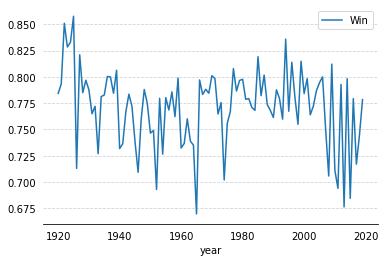

In [20]:
wr_plot = selection_data.groupby('year')[['Win']].mean().plot.line()
adjust_plot(wr_plot)

In [21]:
selection_data.loc[selection_data.year >= 2010, 'Win'].mean()

0.7300627240143369

In [6]:
br['BA'] = br['H'] / br['AB']

In [7]:
merged = pd.merge(br, WinRate, on=['BAT_ID', 'year'])

In [12]:
def adjust_plot(plt):
    plt.xaxis.grid(False)
    plt.yaxis.grid(True, linestyle='dashed', color='lightgrey')
    plt.set_axisbelow(True)
    plt.xaxis.set_ticks_position('none') 
    plt.yaxis.set_ticks_position('none') 

    plt.spines['left'].set_visible(False)
    plt.spines['right'].set_visible(False)
    plt.spines['top'].set_visible(False)

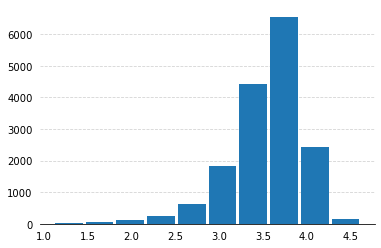

In [9]:
plot = merged.loc[merged.G >= 100 , 'ABPG'].hist(rwidth=0.9)
adjust_plot(plot)

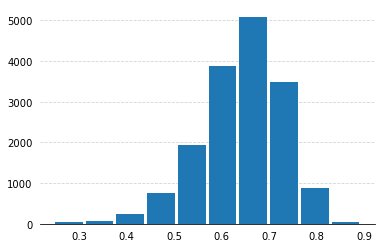

In [10]:
plot = merged.loc[merged.G >= 100 , 'WPG'].hist(rwidth=0.9)
adjust_plot(plot)

In [11]:
merged.loc[(merged.G >= 120) & (merged.WPG > .8)]

,,FirstName,LastName,BAT_HAND,G,AB,H,2B,3B,HR,RBI,...,IW,SO,HBP,SH,SF,BBPG,ABPG,HPG,BA,WPG
BAT_ID,year,,,,,,,,,,,,,,,,,,,,,
aaroh101,1959,Hank,Aaron,1.0,153,625,222,46,7,39,123,...,17,52,4,0,9,0.333333,4.084967,1.45098,0.3552,0.803922
alexd101,1930,Dale,Alexander,1.0,142,555,183,31,7,20,123,...,0,52,2,1,11,0.28169,3.908451,1.288732,0.32973,0.809859
alouf101,1968,Felipe,Alou,1.0,147,605,190,34,4,10,48,...,14,54,4,0,2,0.312925,4.115646,1.292517,0.31405,0.823129
altuj001,2014,Jose,Altuve,1.0,158,660,225,47,3,7,59,...,7,53,5,1,5,0.227848,4.177215,1.424051,0.340909,0.803797
appll101,1936,Luke,Appling,1.0,132,504,196,31,7,6,120,...,5,25,1,6,0,0.583333,3.818182,1.484848,0.388889,0.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wanep101,1937,Paul,Waner,0.0,147,592,209,29,9,2,71,...,5,34,0,7,0,0.428571,4.027211,1.421769,0.353041,0.823129
wheaz101,1924,Zack,Wheat,0.0,132,534,203,41,7,14,93,...,6,16,3,0,5,0.348485,4.045455,1.537879,0.38015,0.840909
whitp103,1930,Pinky,Whitney,1.0,131,534,183,37,4,7,111,...,0,35,1,5,10,0.236641,4.076336,1.396947,0.342697,0.816794


In [12]:
merged.loc[
    (merged.G >= 120) &
    (merged.WPG > .8) & 
    (merged.index.get_level_values('year') >= 1990),
    ['FirstName', 'LastName', 'G', 'ABPG', 'BA', 'HPG', 'WPG']
].sort_values(['year'])

,,FirstName,LastName,G,ABPG,BA,HPG,WPG
BAT_ID,year,,,,,,,
bichd001,1995,Dante,Bichette,139,4.165468,0.340242,1.417266,0.820144
rodra001,1996,Alex,Rodriguez,146,4.116438,0.357737,1.472603,0.821918
thomf001,1996,Frank,Thomas,141,3.737589,0.349146,1.304965,0.836879
gwynt001,1997,Tony,Gwynn,149,3.973154,0.371622,1.47651,0.838926
vaugm001,1998,Mo,Vaughn,154,3.954545,0.336617,1.331169,0.805195
garcn001,1998,Nomar,Garciaparra,143,4.223776,0.322848,1.363636,0.839161
walkl001,1998,Larry,Walker,127,3.574803,0.363436,1.299213,0.803150
vizqo001,1999,Omar,Vizquel,144,3.986111,0.332753,1.326389,0.805556
rodri001,1999,Ivan,Rodriguez,142,4.225352,0.331667,1.401408,0.802817


In [13]:
test = pd.merge(bg.reset_index(), br[['G', 'BA', 'HPG', 'ABPG']].reset_index(), on=['BAT_ID', 'year'])

In [14]:
test2 = pd.merge(test, gl[['GAME_ID', 'ParkID', 'Date']], on=['GAME_ID'])

In [15]:
test3 = pd.merge(test2, pr[['factor_year', 'factor']], on=['ParkID', 'year'])

In [16]:
test3 = test3[test3.G >= 100]
test3 = test3.set_index(['GAME_ID', 'BAT_ID'])

test3['adj_BA'] = test3['BA'] * test3['factor']

test4 = test3.groupby('Date')['adj_BA'].nlargest(2).to_frame()
test4 = test4.sort_values(by=['Date', 'adj_BA', 'GAME_ID'], ascending=[True, False, True])
test4['pick_order'] = test4.groupby(['Date']).cumcount()+1

selection_data = test4.merge(test3[['Date', 'Win', 'year']], on =['GAME_ID', 'BAT_ID'])
selection_data = selection_data.set_index(['Date', 'pick_order'])

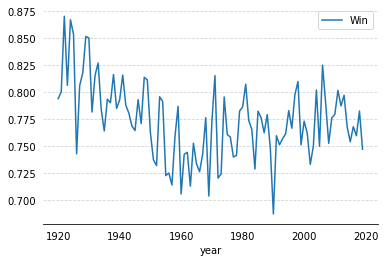

In [29]:
wr_plot = selection_data.groupby('year')[['Win']].mean().plot.line()
adjust_plot(wr_plot)

In [30]:
selection_data.loc[selection_data.year >= 2010, 'Win'].mean()

0.774523348991434

In [90]:
def streak_counter(df):
    df['L_Win'] = df['Win'].shift(1)
    df['L_year'] = df['year'].shift(1)
    df['start_of_streak'] = (df['Win'] != df['L_Win']) | (df['year'] != df['L_year'])
    df['streak_id'] = df['start_of_streak'].cumsum()
    df['streak_counter'] = df.groupby('streak_id').cumcount() + 1
    df.loc[df.Win == 0, 'streak_counter'] = 0
    
    return df

In [91]:
selection_data = selection_data.astype({'Win':'int8'})
selection_data = streak_counter(selection_data)
streaks = selection_data.groupby('streak_id').agg({'streak_counter':'max'})
streaks['streak_counter'].max()

55

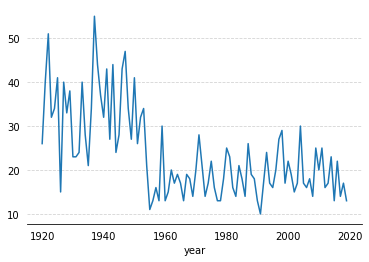

In [92]:
year_results = selection_data.groupby('year').agg({'Win':'mean', 'streak_counter':'max'})
st_plot = year_results['streak_counter'].plot()
adjust_plot(st_plot)

In [22]:
fp = pd.merge(panel, bg, on=['GAME_ID', 'BAT_ID'])

In [23]:
fp = fp[['Win', 'GAME_ID', 'ParkID', 'BAT_ID', 'PIT_ID', 'home']]

In [24]:
fp.dtypes

Win          Int8
GAME_ID    object
ParkID     string
BAT_ID     object
PIT_ID     string
home         Int8
dtype: object

In [25]:
fp['Win'] = fp['Win'].astype('int')